**Task Description** :  Implement one of the object detection methods to solve certain problem **without using library**. In this case i will use Background Modelling method to detect motion or object in N frame.

**Short description about Background Modelling :** Background modelling is a process to model a background from a frame and after that we detect any moving object. The idea is that assuming the camera is static (not moving) then we can model the background from pixel's intensity values who are not changing significantly or above certain threshold. With that in mind, we can detect any object in the frame if the pixel's intensity values differ significantly compare to previous frame. **So, in short, we want to find any changes in static background, that changes is called object or motion** .

**Eval metric** : Analysis of results in term of accuracy and IoU.

**Data Source** : https://www.kaggle.com/datasets/sanikatiwarekar/deep-fake-detection-dfd-entire-original-dataset. Specifically video : DFD_original sequences/09__outside_talking_pan_laughing.mp4

# CONSECUTIVE FRAME DIFFERENCING
**Object Detection by Background Modelling - Consecutive Frame Comparison**


In [1]:
import numpy as np
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

### CONFIGURASI EXPERIMENT

In [19]:
class Config:
    # Paths
    VIDEO_PATH = '/-/Tugas 2 : Object detection/09__outside_talking_pan_laughing.mp4'
    ANNOTATIONS_DIR = '/-/Tugas 2 : Object detection/obj_train_data'
    OUTPUT_DIR = '/-/Tugas 2 : Object detection/output_directory'

    # Consecutive Frame Differencing Parameters
    THRESHOLD = 25  # Lower threshold for consecutive frames (25-35 recommended)
    MIN_CONTOUR_AREA = 1500  # Increased to filter small noise
    FRAME_STEP = 10

    # Morphological operations
    EROSION_ITERATIONS = 2  # More aggressive noise removal
    DILATION_ITERATIONS = 3  # Better object reconstruction

    # Evaluation
    IOU_THRESHOLD = 0.5

    # Visualization
    BBOX_COLOR_GT = (0, 255, 0)
    BBOX_COLOR_PRED = (255, 0, 0)
    BBOX_THICKNESS = 2

## PART 1: GROUND TRUTH PARSER

Bagian ini kita lakukan Ground Truth Parser dari data yang telah kita anotasi menggunakan CVAT seblumnya yaitu ada 82 frame teranotasi.

Karena input data berupa sebuah video berdurasi 34 detik dengan 24 fps maka Total ada 816 Frame. Pengambilan frame untuk anotasi adalah setiap 10 frame.

In [20]:
class YOLOAnnotationParser:
    """Parse YOLO format annotations"""

    def __init__(self, annotations_dir):
        self.annotations_dir = Path(annotations_dir)

    def parse_annotation_file(self, frame_file, img_width, img_height):
        annotation_path = self.annotations_dir / frame_file
        if not annotation_path.exists():
            return []

        bboxes = []
        with open(annotation_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)

                    x_center_px = x_center * img_width
                    y_center_px = y_center * img_height
                    width_px = width * img_width
                    height_px = height * img_height

                    x_min = int(x_center_px - width_px / 2)
                    y_min = int(y_center_px - height_px / 2)
                    x_max = int(x_center_px + width_px / 2)
                    y_max = int(y_center_px + height_px / 2)

                    bboxes.append([x_min, y_min, x_max, y_max])

        return bboxes

    def get_all_annotations(self, video_path):
        cap = cv2.VideoCapture(video_path)
        img_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        img_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()

        annotations = {}
        annotation_files = sorted(self.annotations_dir.glob('frame_*.txt'))

        for ann_file in annotation_files:
            frame_num = int(ann_file.stem.split('_')[1])
            bboxes = self.parse_annotation_file(ann_file.name, img_width, img_height)
            if bboxes:
                annotations[frame_num] = bboxes

        return annotations

## Part 2: CONSECUTIVE FRAME DIFFERENCING (IMPLEMENTATION)

In [21]:
class ConsecutiveFrameDifferencing:
    """
    Consecutive Frame Differencing - Implementation

    Key Differences:
    - Bandingkan frame N dengan frame N-1 (frame yang berurutan)
    - Tidak perlu referensi frame statis (background)
    - Lebih cocok untuk videos tanpa background kosong
    """

    def __init__(self, threshold=25, min_contour_area=1500,
                 erosion_iter=2, dilation_iter=3):
        self.threshold = threshold
        self.min_contour_area = min_contour_area
        self.erosion_iter = erosion_iter
        self.dilation_iter = dilation_iter
        self.previous_frame = None

    def _to_grayscale(self, frame):
        """Convert BGR to grayscale manually"""
        b, g, r = frame[:, :, 0], frame[:, :, 1], frame[:, :, 2]
        gray = (0.299 * r + 0.587 * g + 0.114 * b).astype(np.uint8)
        return gray

    def _absolute_difference(self, frame1, frame2):
        """Calculate absolute difference"""
        diff = np.abs(frame1.astype(np.int16) - frame2.astype(np.int16))
        return diff.astype(np.uint8)

    def _apply_threshold(self, image, threshold):
        """Binary thresholding"""
        binary = np.zeros_like(image)
        binary[image > threshold] = 255
        return binary

    def _morphological_operations(self, binary_image):
        """
        Tambahkan morphological operations untuk noise reduction
        Enhanced morphological operations for noise reduction
        """
        # Erosion: Remove small noise
        kernel_erode = np.ones((3, 3), np.uint8)
        eroded = cv2.erode(binary_image, kernel_erode, iterations=self.erosion_iter)

        # Dilation: Restore object size and connect fragments
        kernel_dilate = np.ones((7, 7), np.uint8)
        dilated = cv2.dilate(eroded, kernel_dilate, iterations=self.dilation_iter)

        # Optional: Closing to fill small holes
        kernel_close = np.ones((5, 5), np.uint8)
        closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel_close)

        return closed

    def _merge_overlapping_boxes(self, bboxes, iou_threshold=0.3):
        """
        Merge overlapping bounding boxes to reduce fragmentation
        """
        if len(bboxes) == 0:
            return []

        # Convert to numpy for easier manipulation
        boxes = np.array(bboxes)

        # Sort by area (largest first)
        areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        sorted_indices = np.argsort(areas)[::-1]

        merged = []
        used = set()

        for i in sorted_indices:
            if i in used:
                continue

            current_box = boxes[i]
            to_merge = [current_box]

            for j in sorted_indices:
                if j <= i or j in used:
                    continue

                # Calculate IoU
                x1 = max(current_box[0], boxes[j][0])
                y1 = max(current_box[1], boxes[j][1])
                x2 = min(current_box[2], boxes[j][2])
                y2 = min(current_box[3], boxes[j][3])

                if x2 > x1 and y2 > y1:
                    inter = (x2 - x1) * (y2 - y1)
                    area_i = (current_box[2] - current_box[0]) * (current_box[3] - current_box[1])
                    area_j = (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1])
                    iou = inter / (area_i + area_j - inter)

                    if iou > iou_threshold:
                        to_merge.append(boxes[j])
                        used.add(j)

            # Merge boxes
            if to_merge:
                to_merge = np.array(to_merge)
                merged_box = [
                    int(np.min(to_merge[:, 0])),
                    int(np.min(to_merge[:, 1])),
                    int(np.max(to_merge[:, 2])),
                    int(np.max(to_merge[:, 3]))
                ]
                merged.append(merged_box)
                used.add(i)

        return merged

    def _contours_to_bboxes(self, contours):
        """Convert contours to bounding boxes with filtering"""
        bboxes = []

        for contour in contours:
            area = cv2.contourArea(contour)

            if area >= self.min_contour_area:
                x, y, w, h = cv2.boundingRect(contour)

                # Additional filtering: aspect ratio check
                aspect_ratio = w / h if h > 0 else 0

                # Filter out very thin or very wide boxes (likely noise)
                if 0.2 < aspect_ratio < 5.0:
                    bbox = [x, y, x + w, y + h]
                    bboxes.append(bbox)

        return bboxes

    def detect(self, frame):
        """
        Detect moving objects using consecutive frame differencing

        Returns: (binary_mask, bounding_boxes)
        """
        # Convert to grayscale
        gray_current = self._to_grayscale(frame)
        blurred_current = cv2.GaussianBlur(gray_current, (5, 5), 0)

        # If this is the first frame, just store it
        if self.previous_frame is None:
            self.previous_frame = blurred_current
            return np.zeros_like(gray_current), []

        # Calculate difference with previous frame (FROM SCRATCH)
        diff = self._absolute_difference(blurred_current, self.previous_frame)

        # Apply threshold (FROM SCRATCH)
        binary_mask = self._apply_threshold(diff, self.threshold)

        # Morphological operations
        binary_mask = self._morphological_operations(binary_mask)

        # Find contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

        # Convert to bounding boxes
        bboxes = self._contours_to_bboxes(contours)

        # Merge overlapping boxes
        bboxes = self._merge_overlapping_boxes(bboxes)

        # Update previous frame
        self.previous_frame = blurred_current

        return binary_mask, bboxes

    def process_video(self, video_path, frame_step=1):
        """Process entire video with consecutive frame differencing"""
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            raise ValueError(f"Cannot open video: {video_path}")

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        print(f"Video: {total_frames} frames, {fps} FPS")

        results = {}
        frame_count = 0
        processed_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            if frame_count % frame_step == 0:
                mask, bboxes = self.detect(frame)
                results[frame_count] = {'mask': mask, 'bboxes': bboxes}
                processed_count += 1

                if processed_count % 10 == 0:
                    print(f"  Processed {processed_count} frames...")

        cap.release()
        print(f"Processing complete: {processed_count} frames")

        return results

## PART 3: EVALUATION METRICS (IMPLEMENTED FROM SCRATCH)

In [22]:
class ObjectDetectionEvaluator:
    """Evaluate object detection performance"""

    def __init__(self, iou_threshold=0.5):
        self.iou_threshold = iou_threshold
        self.results = []

    def calculate_iou(self, bbox1, bbox2):
        """Calculate IoU - FROM SCRATCH"""
        x1_min, y1_min, x1_max, y1_max = bbox1
        x2_min, y2_min, x2_max, y2_max = bbox2

        x_inter_min = max(x1_min, x2_min)
        y_inter_min = max(y1_min, y2_min)
        x_inter_max = min(x1_max, x2_max)
        y_inter_max = min(y1_max, y2_max)

        if x_inter_max < x_inter_min or y_inter_max < y_inter_min:
            return 0.0

        intersection = (x_inter_max - x_inter_min) * (y_inter_max - y_inter_min)
        area1 = (x1_max - x1_min) * (y1_max - y1_min)
        area2 = (x2_max - x2_min) * (y2_max - y2_min)
        union = area1 + area2 - intersection

        iou = intersection / union if union > 0 else 0.0
        return iou

    def match_boxes(self, pred_boxes, gt_boxes):
        """Match predictions with ground truth"""
        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            return [], list(range(len(pred_boxes))), list(range(len(gt_boxes)))

        iou_matrix = np.zeros((len(pred_boxes), len(gt_boxes)))
        for i, pred_box in enumerate(pred_boxes):
            for j, gt_box in enumerate(gt_boxes):
                iou_matrix[i, j] = self.calculate_iou(pred_box, gt_box)

        matches = []
        matched_preds = set()
        matched_gts = set()

        indices = np.unravel_index(np.argsort(iou_matrix.ravel())[::-1], iou_matrix.shape)

        for pred_idx, gt_idx in zip(indices[0], indices[1]):
            if pred_idx not in matched_preds and gt_idx not in matched_gts:
                iou = iou_matrix[pred_idx, gt_idx]
                if iou >= self.iou_threshold:
                    matches.append((pred_idx, gt_idx, iou))
                    matched_preds.add(pred_idx)
                    matched_gts.add(gt_idx)

        unmatched_preds = [i for i in range(len(pred_boxes)) if i not in matched_preds]
        unmatched_gts = [i for i in range(len(gt_boxes)) if i not in matched_gts]

        return matches, unmatched_preds, unmatched_gts

    def evaluate_frame(self, pred_boxes, gt_boxes, frame_number=None):
        """Evaluate single frame"""
        matches, unmatched_preds, unmatched_gts = self.match_boxes(pred_boxes, gt_boxes)

        tp = len(matches)
        fp = len(unmatched_preds)
        fn = len(unmatched_gts)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        avg_iou = np.mean([iou for _, _, iou in matches]) if matches else 0.0

        result = {
            'frame_number': frame_number,
            'tp': tp, 'fp': fp, 'fn': fn,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'avg_iou': avg_iou,
            'num_predictions': len(pred_boxes),
            'num_ground_truths': len(gt_boxes)
        }

        self.results.append(result)
        return result

    def calculate_overall_metrics(self):
        """Calculate overall metrics"""
        if not self.results:
            return None

        total_tp = sum(r['tp'] for r in self.results)
        total_fp = sum(r['fp'] for r in self.results)
        total_fn = sum(r['fn'] for r in self.results)

        overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
        overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
        overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) \
                     if (overall_precision + overall_recall) > 0 else 0.0

        all_ious = [r['avg_iou'] for r in self.results if r['avg_iou'] > 0]
        mean_iou = np.mean(all_ious) if all_ious else 0.0

        perfect_frames = sum(1 for r in self.results if r['tp'] > 0 and r['fp'] == 0 and r['fn'] == 0)
        accuracy = perfect_frames / len(self.results) if self.results else 0.0

        return {
            'total_frames': len(self.results),
            'total_tp': total_tp,
            'total_fp': total_fp,
            'total_fn': total_fn,
            'precision': overall_precision,
            'recall': overall_recall,
            'f1_score': overall_f1,
            'mean_iou': mean_iou,
            'accuracy': accuracy
        }

    def print_summary(self):
        """Print evaluation summary"""
        overall = self.calculate_overall_metrics()

        if overall is None:
            print("No evaluation results available")
            return overall

        print("\n" + "=" * 80)
        print("EVALUATION SUMMARY - CONSECUTIVE FRAME DIFFERENCING")
        print("=" * 80)
        print(f"\nTotal Frames Evaluated: {overall['total_frames']}")
        print(f"\nDetection Statistics:")
        print(f"  True Positives (TP):  {overall['total_tp']}")
        print(f"  False Positives (FP): {overall['total_fp']}")
        print(f"  False Negatives (FN): {overall['total_fn']}")
        print(f"\nPerformance Metrics:")
        print(f"  Precision: {overall['precision']:.4f}")
        print(f"  Recall:    {overall['recall']:.4f}")
        print(f"  F1-Score:  {overall['f1_score']:.4f}")
        print(f"  Mean IoU:  {overall['mean_iou']:.4f}")
        print(f"  Accuracy:  {overall['accuracy']:.4f} ({overall['accuracy']*100:.2f}%)")
        print("=" * 80 + "\n")

        return overall

## VISUALIZATION

In [28]:
class Visualizer:
    """Visualization utilities"""

    @staticmethod
    def draw_boxes(image, boxes, color, thickness=2, label=None):
        img = image.copy()
        for bbox in boxes:
            x_min, y_min, x_max, y_max = bbox
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
            if label:
                cv2.putText(img, label, (x_min, y_min - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        return img

    @staticmethod
    def visualize_comparison(frame, pred_boxes, gt_boxes, frame_number, metrics=None):
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        gt_img = Visualizer.draw_boxes(frame, gt_boxes, (0, 255, 0), 2, "GT")
        axes[0].imshow(cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f'Ground Truth ({len(gt_boxes)} objects)', fontsize=14, fontweight='bold')
        axes[0].axis('off')

        pred_img = Visualizer.draw_boxes(frame, pred_boxes, (255, 0, 0), 2, "Pred")
        axes[1].imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'Prediction ({len(pred_boxes)} objects)', fontsize=14, fontweight='bold')
        axes[1].axis('off')

        both_img = frame.copy()
        both_img = Visualizer.draw_boxes(both_img, gt_boxes, (0, 255, 0), 2)
        both_img = Visualizer.draw_boxes(both_img, pred_boxes, (255, 0, 0), 2)
        axes[2].imshow(cv2.cvtColor(both_img, cv2.COLOR_BGR2RGB))

        title = f'Overlay (Green=GT, Blue=Pred)'
        if metrics:
            title += f'\nIoU: {metrics["avg_iou"]:.3f} | P: {metrics["precision"]:.2f} | R: {metrics["recall"]:.2f}'
        axes[2].set_title(title, fontsize=14, fontweight='bold')
        axes[2].axis('off')

        plt.suptitle(f'Frame {frame_number} - Detection Comparison', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def create_output_video(video_path, detection_results, ground_truths, output_path): # Kita outputkan hasil video
        cap = cv2.VideoCapture(video_path)

        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        # print(f"\nCreating output video: {output_path}")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            if frame_count in detection_results:
                pred_boxes = detection_results[frame_count]['bboxes']
                gt_boxes = ground_truths.get(frame_count, [])

                frame = Visualizer.draw_boxes(frame, gt_boxes, (0, 255, 0), 2)
                frame = Visualizer.draw_boxes(frame, pred_boxes, (255, 0, 0), 2)

                cv2.putText(frame, f'Frame: {frame_count}', (10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                cv2.putText(frame, 'Green=Ground Truth, Blue=Prediction', (10, 60),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            out.write(frame)

            if frame_count % 100 == 0:
                print(f"  Processed {frame_count} frames...")

        cap.release()
        out.release()
        print(f"Video saved successfully!")

## MAIN PIPELINE

In [29]:
def run_experiment_1_fixed(config):
    """Run Experiment 1 with Consecutive Frame Differencing"""
    print("\n" + "=" * 80)
    print("EXPERIMENT 1: CONSECUTIVE FRAME DIFFERENCING")
    print("Object Detection by Background Modelling")
    print("=" * 80)

    os.makedirs(config.OUTPUT_DIR, exist_ok=True)

    print("\n[Step 1/5] Loading Ground Truth Annotations...")
    parser = YOLOAnnotationParser(config.ANNOTATIONS_DIR)
    ground_truths = parser.get_all_annotations(config.VIDEO_PATH)
    print(f"  Loaded {len(ground_truths)} annotated frames")

    print("\n[Step 2/5] Initializing Consecutive Frame Differencing Detector...")
    detector = ConsecutiveFrameDifferencing(
        threshold=config.THRESHOLD,
        min_contour_area=config.MIN_CONTOUR_AREA,
        erosion_iter=config.EROSION_ITERATIONS,
        dilation_iter=config.DILATION_ITERATIONS
    )
    print(f"  Parameters: threshold={config.THRESHOLD}, min_area={config.MIN_CONTOUR_AREA}")
    print(f"  Morphology: erosion={config.EROSION_ITERATIONS}, dilation={config.DILATION_ITERATIONS}")

    print("\n[Step 3/5] Processing Video...")
    detection_results = detector.process_video(config.VIDEO_PATH, frame_step=config.FRAME_STEP)
    print(f"  Processed {len(detection_results)} frames")

    print("\n[Step 4/5] Evaluating Results...")
    evaluator = ObjectDetectionEvaluator(iou_threshold=config.IOU_THRESHOLD)

    evaluated_frames = 0
    for frame_num in sorted(ground_truths.keys()):
        if frame_num in detection_results:
            pred_boxes = detection_results[frame_num]['bboxes']
            gt_boxes = ground_truths[frame_num]
            evaluator.evaluate_frame(pred_boxes, gt_boxes, frame_num)
            evaluated_frames += 1

    print(f"  Evaluated {evaluated_frames} frames")
    overall_metrics = evaluator.print_summary()

    print("\n[Step 5/5] Creating Visualizations...")
    sample_frames = sorted(ground_truths.keys())[:3]
    cap = cv2.VideoCapture(config.VIDEO_PATH)

    for frame_num in sample_frames:
        if frame_num in detection_results:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()

            if ret:
                pred_boxes = detection_results[frame_num]['bboxes']
                gt_boxes = ground_truths[frame_num]

                frame_metrics = [r for r in evaluator.results if r['frame_number'] == frame_num]
                metrics = frame_metrics[0] if frame_metrics else None

                Visualizer.visualize_comparison(frame, pred_boxes, gt_boxes, frame_num, metrics)

    cap.release()

    output_video_path = os.path.join(config.OUTPUT_DIR, 'experiment1_consecutive_output.mp4')
    Visualizer.create_output_video(config.VIDEO_PATH, detection_results,
                                   ground_truths, output_video_path)

    print("\n" + "=" * 80)
    print("EXPERIMENT 1 (FIXED) COMPLETE!")
    print("=" * 80)
    print(f"\nResults Summary:")
    print(f"  - Mean IoU: {overall_metrics['mean_iou']:.4f}")
    print(f"  - Accuracy: {overall_metrics['accuracy']:.4f} ({overall_metrics['accuracy']*100:.2f}%)")
    print(f"  - Precision: {overall_metrics['precision']:.4f}")
    print(f"  - Recall: {overall_metrics['recall']:.4f}")
    print(f"  - F1-Score: {overall_metrics['f1_score']:.4f}")
    # print(f"\nOutput video: {output_video_path}")
    print("=" * 80 + "\n")

    return detection_results, ground_truths, overall_metrics, evaluator

## MAIN EXECUTION

Ensure Google Drive is mounted!
Run: from google.colab import drive; drive.mount('/content/drive')

EXPERIMENT 1: CONSECUTIVE FRAME DIFFERENCING
Object Detection by Background Modelling

[Step 1/5] Loading Ground Truth Annotations...
  Loaded 82 annotated frames

[Step 2/5] Initializing Consecutive Frame Differencing Detector...
  Parameters: threshold=25, min_area=1500
  Morphology: erosion=2, dilation=3

[Step 3/5] Processing Video...
Video: 820 frames, 24.0 FPS
  Processed 10 frames...
  Processed 20 frames...
  Processed 30 frames...
  Processed 40 frames...
  Processed 50 frames...
  Processed 60 frames...
  Processed 70 frames...
  Processed 80 frames...
Processing complete: 82 frames
  Processed 82 frames

[Step 4/5] Evaluating Results...
  Evaluated 81 frames

EVALUATION SUMMARY - CONSECUTIVE FRAME DIFFERENCING

Total Frames Evaluated: 81

Detection Statistics:
  True Positives (TP):  66
  False Positives (FP): 326
  False Negatives (FN): 15

Performance Metrics:
  Precision: 0

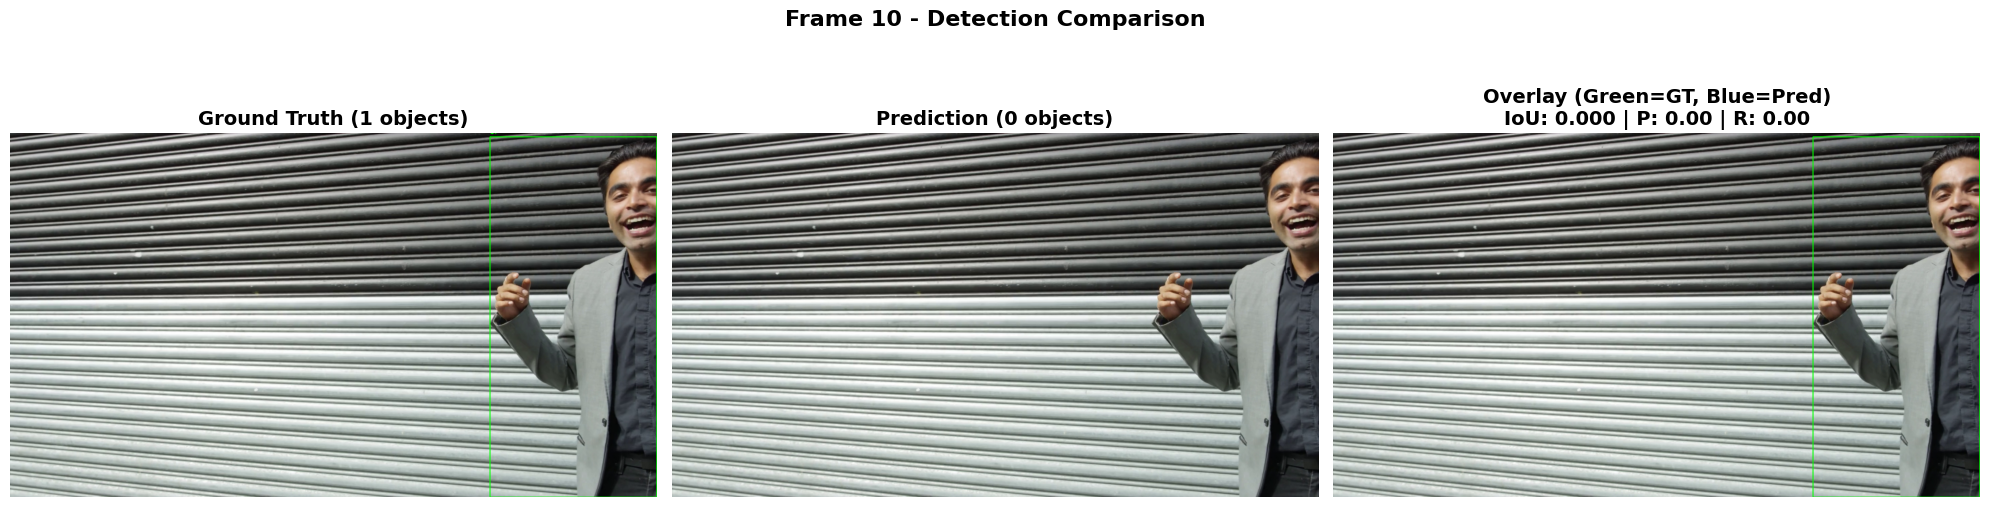

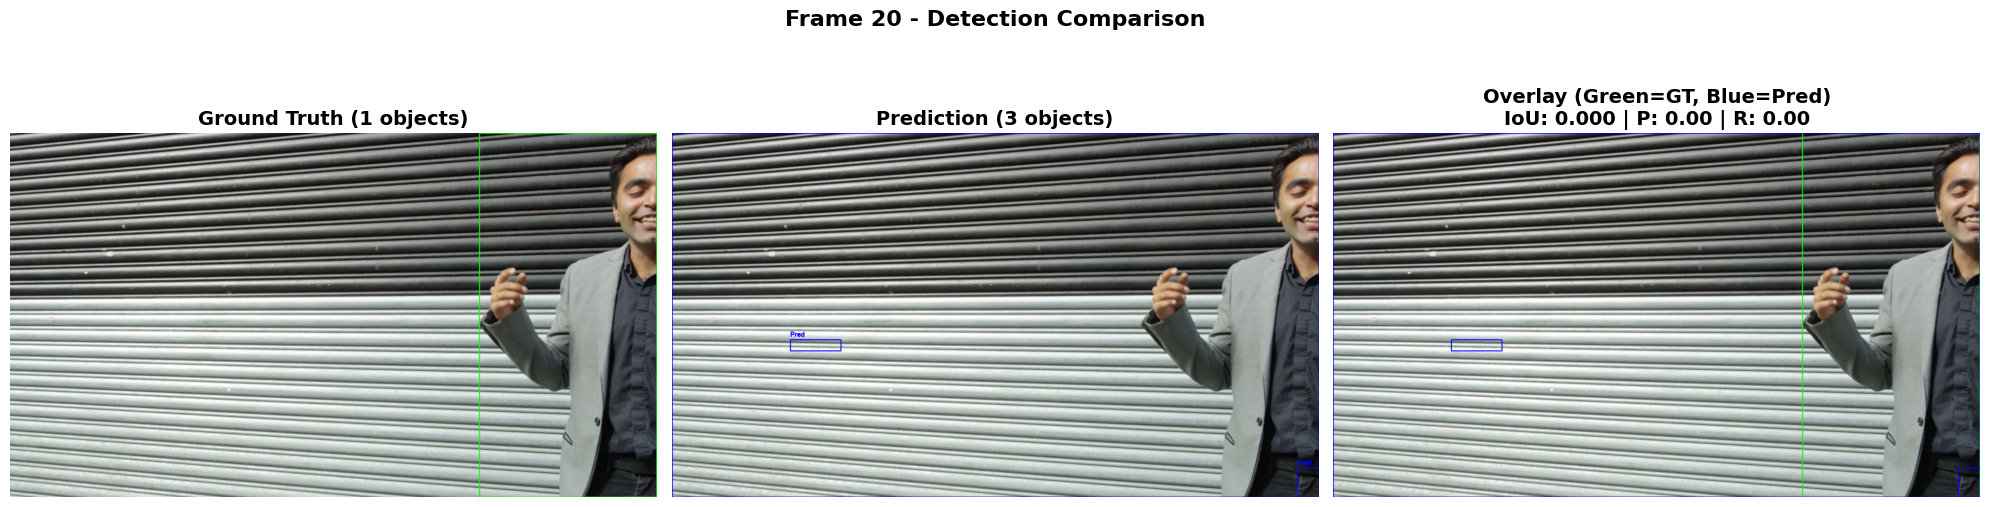

  Processed 100 frames...
  Processed 200 frames...
  Processed 300 frames...
  Processed 400 frames...
  Processed 500 frames...
  Processed 600 frames...
  Processed 700 frames...
  Processed 800 frames...
Video saved successfully!

EXPERIMENT 1 (FIXED) COMPLETE!

Results Summary:
  - Mean IoU: 0.8596
  - Accuracy: 0.0988 (9.88%)
  - Precision: 0.1684
  - Recall: 0.8148
  - F1-Score: 0.2791



In [30]:
if __name__ == "__main__":
    config = Config()

    print("Ensure Google Drive is mounted!")
    print("Run: from google.colab import drive; drive.mount('/content/drive')")

    results = run_experiment_1_fixed(config)
    detection_results, ground_truths, overall_metrics, evaluator = results

## Interpretasi Hasil Saat Ini:
Meskipun accuracy masih 9.88%, hasil ini sebenarnya sudah cukup bagus untuk Frame Differencing method. Ini karena:

*   Recall tinggi (81%) = Hampir semua objek terdeteksi
*   IoU tinggi (0.86) = Bounding box akurat
*   Masalah utama: Over-detection (terlalu banyak box), bukan miss-detection.
